In [14]:
import sys
from pathlib import Path
sys.path.append(str(Path("./multiscale-ssh")))  # replace with real path

from DL_models import UNet  
from DL_models import CNN
from FCNN import FCNN
from loss_function import CombinedLoss
from train_test import train_model
from train_test import evaluate_model_sr
from visualization import plot_predictions_vs_targets, plot_predictions_vs_targets_sr
from visualization import plot_mean_power_spectrum, plot_mean_power_spectrum_sr
from visualization import plot_train_val_losses
from visualization import plot_mean_esr
from dataloading import prepare_dataloaders, prepare_dataloaders_multiVar
from qualitative_eval import mse, r2_score, pearson_corr, first_esr_exceeds_half

In [15]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
# import preprocessing
import os
import xrft
import gcm_filters
import random
import scipy
from scipy.ndimage import convolve

warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

# Data Pre-processing

In [16]:
ds_HR = xr.open_dataset("gs://leap-persistent/panalluri/ds_HR.zarr", engine="zarr", chunks={}) 
ds_LR = xr.open_dataset("gs://leap-persistent/panalluri/ds_LR.zarr", engine="zarr", chunks={}) 
ds_HF = xr.open_dataset("gs://leap-persistent/panalluri/ds_HF.zarr", engine="zarr", chunks={}) 

In [17]:
# Select region of interest
ds_HR_reg = ds_HR.isel(xt_ocean=slice(1100,1300), yt_ocean=slice(1500,1800))
ds_LR_reg = ds_LR.isel(xt_ocean=slice(1100,1300), yt_ocean=slice(1500,1800))
ds_HF_reg = ds_HF.isel(xt_ocean=slice(1100,1300), yt_ocean=slice(1500,1800))

In [18]:
var_LR = ['u_relative', 'v_relative', 't_ref', 'surface_temp', 'q_ref', 'slp']
train_loader, val_loader, test_loader, HF_test, LR_test = prepare_dataloaders_multiVar(ds_HF_reg, ds_LR_reg, var_LR=var_LR, var_HF='heatflux_diff', batch_size=32)

Training set size: 510
Validation set size: 109
Testing set size: 111


# ML Model Training

In [19]:
# Config choices Abigail chose

input_channels = 6
output_channels = 1
conv_layers = 7
kernel = 5
#init_bound = 0.5
kernel_hidden = 3
activation = "ReLU"
arch = "fcnn"

config={"input_channels":input_channels,
        "output_channels":output_channels,
        "activation":activation,
        "arch":arch,
        "conv_layers":conv_layers,
        "kernel":kernel,
        "kernel_hidden":kernel_hidden}

In [20]:
model = FCNN(config=config)
model

FCNN(
  (conv): Sequential(
    (0): Conv2d(6, 128, kernel_size=(5, 5), stride=(1, 1), padding=same, padding_mode=reflect)
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (7): ReLU()
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (10): ReLU()
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (13): ReLU()
    (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, affi

In [21]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_losses, val_losses = train_model(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_trial_FCNN_SGS.pth',
            n_epochs=1) # n_epochs=2000)

Trainable Parameters: 149569
Epoch 1, Train Loss: 4.315e+01, Val Loss: 9.186e+01, Epoch Time: 292.68s
Model saved at epoch 1
Training complete


In [22]:
device = torch.device("cpu")
sgs_pred = evaluate_model_sr(model, device, test_loader, HF_test, './model_trial_FCNN_SGS.pth')
sgs_pred

Loaded model parameters from ./model_trial_FCNN_SGS.pth


array([[[3.1305125, 3.1303983, 3.1308722, ..., 3.1622796, 3.1621537,
         3.1622713],
        [3.128479 , 3.1283672, 3.1288395, ..., 3.1597738, 3.1596437,
         3.1597595],
        [3.1223989, 3.1222813, 3.1227438, ..., 3.152294 , 3.152162 ,
         3.152277 ],
        ...,
        [3.4097874, 3.4095807, 3.4104412, ..., 3.3638613, 3.3644865,
         3.3637955],
        [3.4042592, 3.4040627, 3.4049425, ..., 3.3590002, 3.3595939,
         3.3588963],
        [3.4012604, 3.4010658, 3.401969 , ..., 3.3566015, 3.3571918,
         3.3565016]],

       [[3.1091325, 3.109013 , 3.1096888, ..., 3.1797378, 3.1793551,
         3.1797552],
        [3.10732  , 3.1072025, 3.107874 , ..., 3.1775115, 3.1771357,
         3.1775322],
        [3.1019146, 3.1018028, 3.1024957, ..., 3.170929 , 3.170554 ,
         3.1709502],
        ...,
        [3.4919474, 3.4916875, 3.4928129, ..., 3.2406073, 3.243827 ,
         3.2399275],
        [3.4737053, 3.4734488, 3.4745984, ..., 3.2313385, 3.2345986,
   

# Visualizations

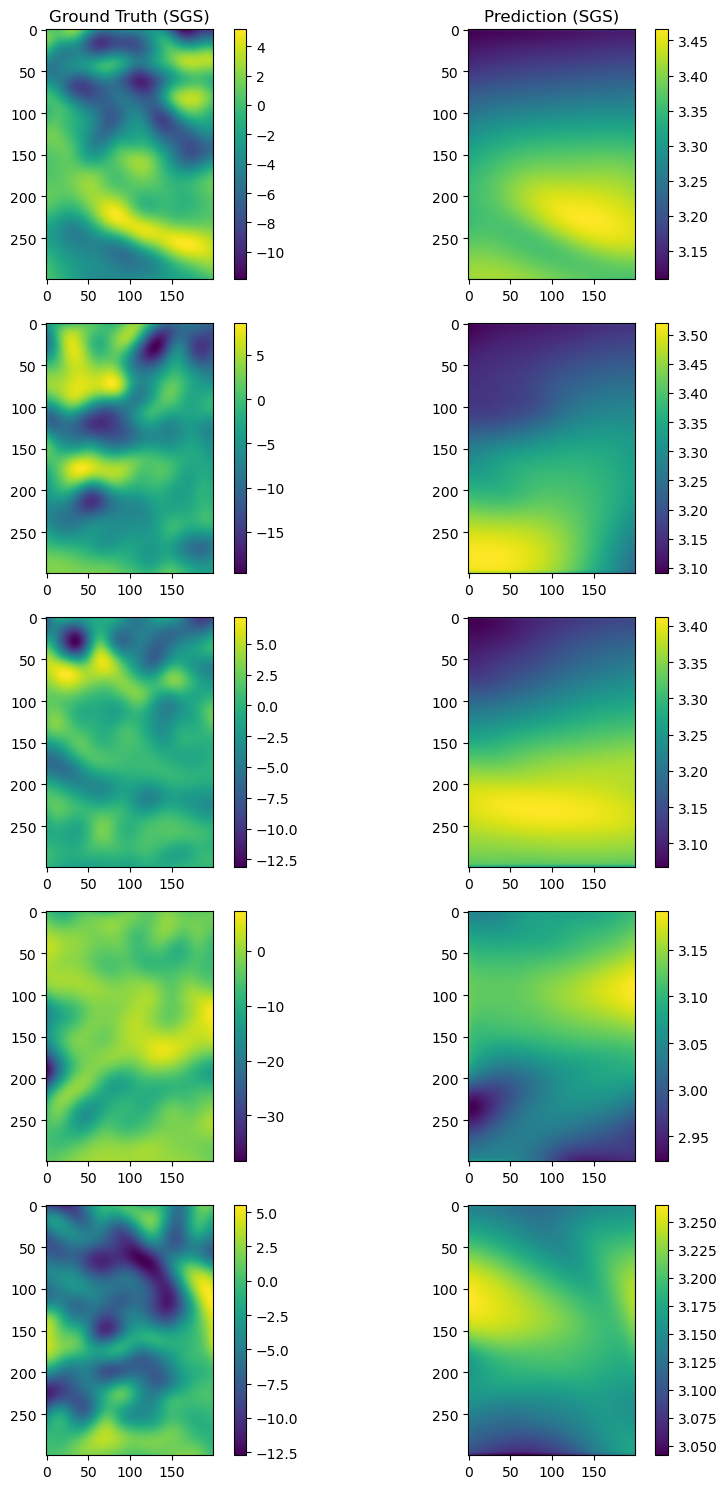

In [23]:
plot_predictions_vs_targets(HF_test, sgs_pred, num_samples=5, cmap='viridis', cbar_shared_lims=False)

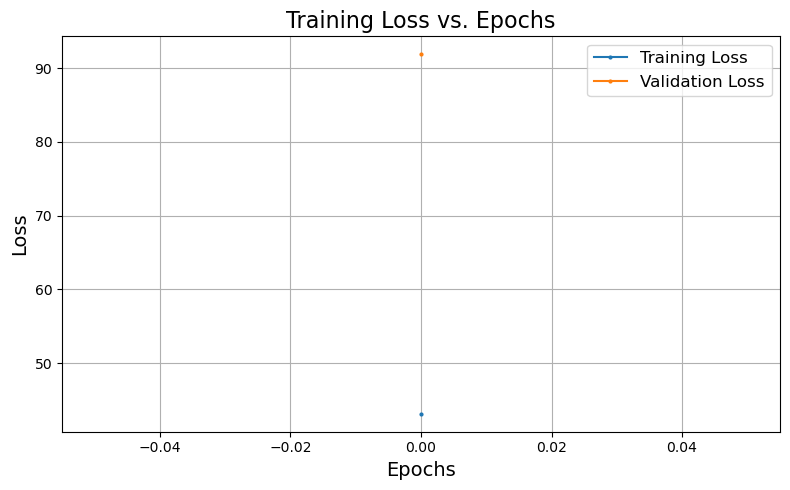

In [24]:
plot_train_val_losses(train_losses, val_losses)

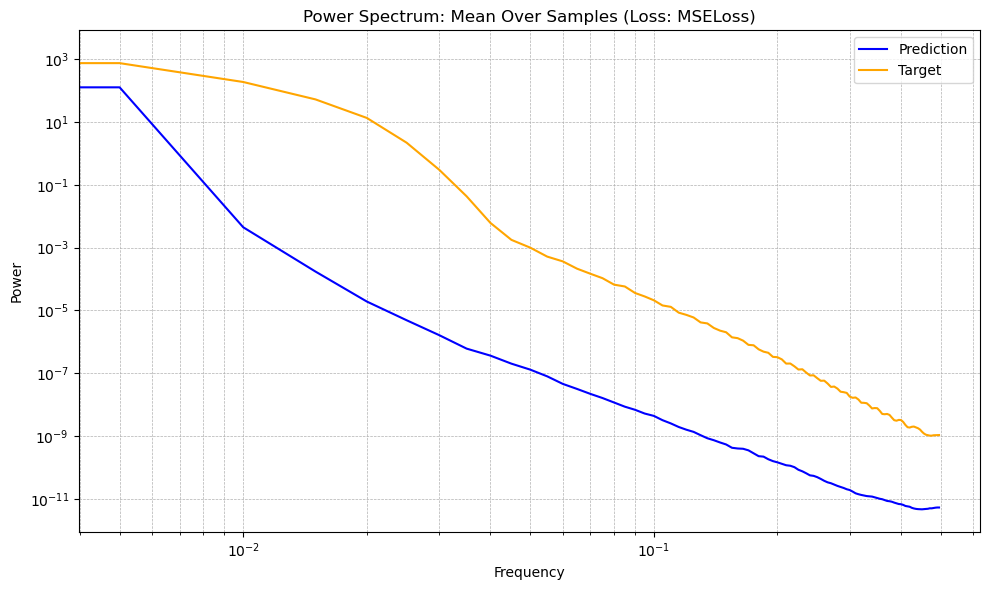

In [25]:
plot_mean_power_spectrum(sgs_pred, HF_test, loss_name="MSELoss", alpha_label="", figsize=(10, 6), show_slopes=False)

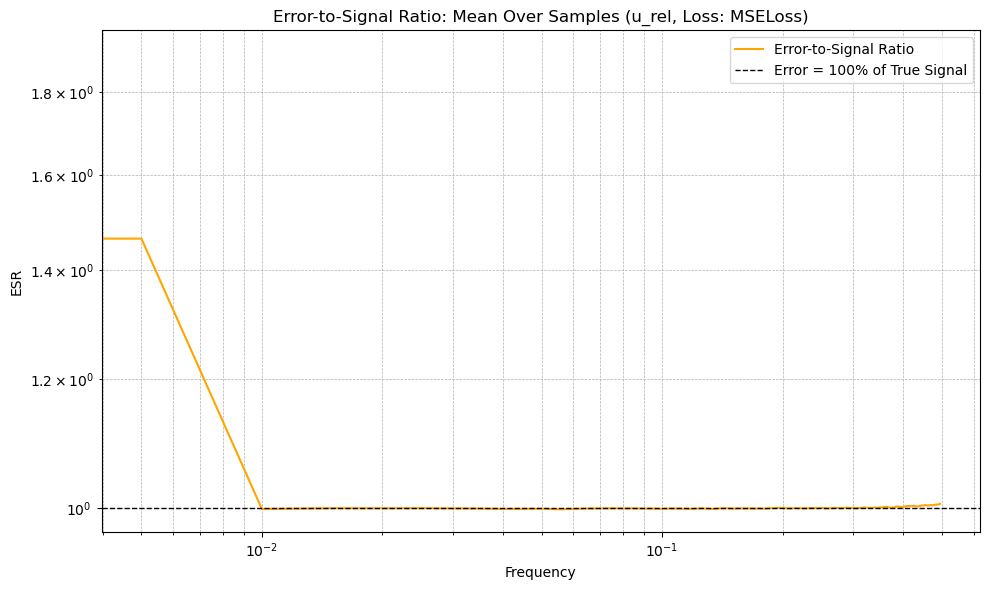

In [26]:
plot_mean_esr(sgs_pred, HF_test, loss_name="MSELoss", alpha_label="", figsize=(10, 6))

# Quantitative Metrics

In [27]:
mse(HF_test, sgs_pred)

75.69332122802734

In [28]:
pearson_corr(HF_test, sgs_pred)

0.10921499186645288

In [29]:
r2_score(HF_test, sgs_pred)

-0.9168801307678223

In [30]:
k_thresh = first_esr_exceeds_half(sgs_pred, HF_test)
k_thresh

All frequencies have ESR > 0.5
